In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import joblib

In [2]:
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

In [3]:
# 1) Configuration — set your CSV path here
file_path = r"Match_Winner_Cleaned.csv"  # <<< CHANGE THIS
RANDOM_STATE = 42
CV_FOLDS = 5
SAVE_MODEL = True
SAVE_DIR = "./models"

# 2) Load dataset (safe-check)
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found. Update file_path to the correct location: {file_path}")

df = pd.read_csv(file_path)
print("Loaded dataset shape:", df.shape)
display(df.head(5))


Loaded dataset shape: (6840, 40)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [4]:
# -------------------------
# 2) Quick checks & cleaning
# -------------------------

# REMOVE Unnamed columns first
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print("After removing Unnamed columns → shape:", df.shape)

# Missing Values
print("\nMissing values per column:\n", df.isnull().sum())

# Duplicate check
print("\nDuplicate rows present?:", df.duplicated().any())
if df.duplicated().any():
    print("Dropping duplicate rows...")
    df = df.drop_duplicates().reset_index(drop=True)
    print("New shape:", df.shape)

# Drop rows with important missing values
required_cols = ['FTR', 'HTGS', 'ATGS', 'HTP', 'ATP']

# Keep only columns that exist (in case some aren't in your CSV)
required_cols = [c for c in required_cols if c in df.columns]

df = df.dropna(subset=required_cols, how='any').reset_index(drop=True)
print("After dropping rows with crucial NA → shape:", df.shape)


After removing Unnamed columns → shape: (6840, 39)

Missing values per column:
 Date             0
HomeTeam         0
AwayTeam         0
FTHG             0
FTAG             0
FTR              0
HTGS             0
ATGS             0
HTGC             0
ATGC             0
HTP              0
ATP              0
HM1              0
HM2              0
HM3              0
HM4              0
HM5              0
AM1              0
AM2              0
AM3              0
AM4              0
AM5              0
MW               0
HTFormPtsStr     0
ATFormPtsStr     0
HTFormPts        0
ATFormPts        0
HTWinStreak3     0
HTWinStreak5     0
HTLossStreak3    0
HTLossStreak5    0
ATWinStreak3     0
ATWinStreak5     0
ATLossStreak3    0
ATLossStreak5    0
HTGD             0
ATGD             0
DiffPts          0
DiffFormPts      0
dtype: int64

Duplicate rows present?: False
After dropping rows with crucial NA → shape: (6840, 39)


In [5]:
# ---- CELL 3: CLEAN DATA ----
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print("After removing Unnamed columns:", df.shape)
# ---- CELL 4: SHOW HEAD ----
print("First 5 rows after cleaning:")
df.head()


After removing Unnamed columns: (6840, 39)
First 5 rows after cleaning:


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,19/08/00,Charlton,Man City,4,0,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,19/08/00,Leeds,Everton,2,0,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0



Target (FTR) value counts:
FTR
NH    3664
H     3176
Name: count, dtype: int64


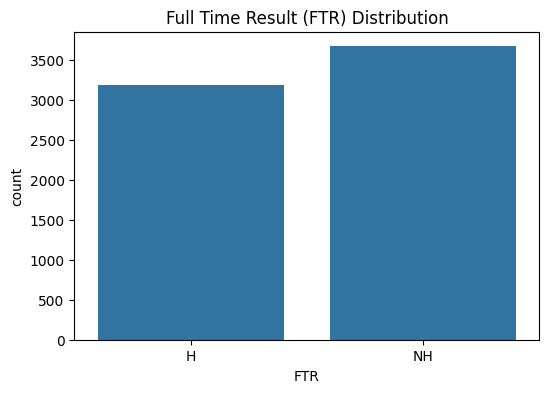

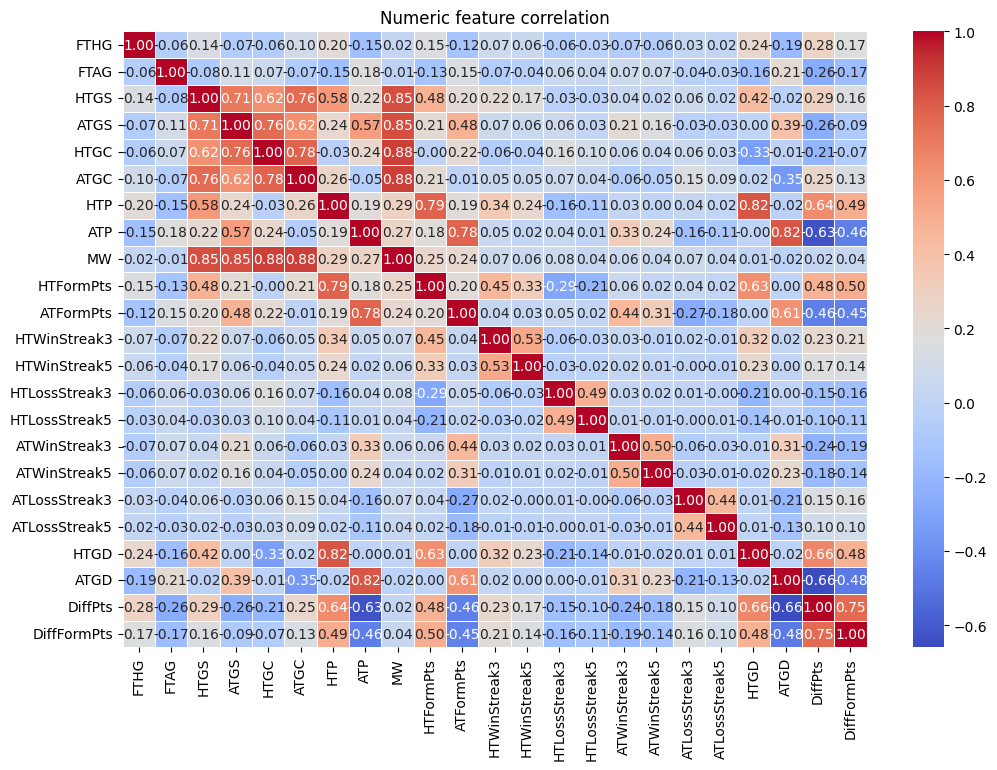

In [6]:
print("\nTarget (FTR) value counts:")
print(df['FTR'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='FTR', data=df)
plt.title('Full Time Result (FTR) Distribution')
plt.show()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
    plt.title('Numeric feature correlation')
    plt.show()


In [7]:
# -------------------------
# 4) Feature engineering (teacher-approved)
# -------------------------

# Remove data-leakage features: do NOT use current match goals
# df['home_goal_diff'] = df['HTGS'] - df['ATGS']   # removed
# df['total_goals'] = df['HTGS'] + df['ATGS']     # removed

# Print info
print("\nNo leakage features added. Using only pre-match stats.")

# Keep form-related columns only
possible_form_cols = [c for c in df.columns if 'Form' in c or 'form' in c or 'WinStreak' in c]
print("Form-like columns detected:", possible_form_cols)

# If you have pre-match points, home/away points, include them
pre_match_cols = [c for c in ['HTP', 'ATP', 'DiffPts', 'DiffFormPts'] if c in df.columns]

# Build final feature list
features = pre_match_cols + possible_form_cols
print("Using features for ML:", features)



No leakage features added. Using only pre-match stats.
Form-like columns detected: ['HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'ATWinStreak3', 'ATWinStreak5', 'DiffFormPts']
Using features for ML: ['HTP', 'ATP', 'DiffPts', 'DiffFormPts', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'ATWinStreak3', 'ATWinStreak5', 'DiffFormPts']


In [8]:
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 1) Define possible form columns (pre-match stats)
# -----------------------------
possible_form_cols = [
    'TFormPtsStr','ATFormPtsStr','HTFormPts','ATFormPts',
    'HomeForm5Pts','AwayForm5Pts','HTFormPtsStr','ATFormPtsStr'
]

# -----------------------------
# 2) Build feature list (teacher-approved)
# -----------------------------
features = []

# Only pre-match stats — NO home_goal_diff or total_goals
for col in ['HTGS','ATGS','HTGC','ATGC','HTP','ATP']:
    if col in df.columns:
        features.append(col)

# Add form-related columns if they exist
features += [c for c in possible_form_cols if c in df.columns]

print("Using features:", features)

# -----------------------------
# 3) Encode target
# -----------------------------
le_ftr = LabelEncoder()
df['FTR_encoded'] = le_ftr.fit_transform(df['FTR'].astype(str))
print("FTR mapping:", dict(zip(le_ftr.classes_, le_ftr.transform(le_ftr.classes_))))

# -----------------------------
# 4) Define X and y
# -----------------------------
X = df[features].copy()
y = df['FTR_encoded'].copy()








Using features: ['HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTFormPtsStr', 'ATFormPtsStr']
FTR mapping: {'H': np.int64(0), 'NH': np.int64(1)}


In [9]:

# -------------------------
# 6) Train-test split (stratify to preserve class proportions)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTrain/test shapes:", X_train.shape, X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


Train/test shapes: (5472, 11) (1368, 11)
y_train distribution:
 FTR_encoded
1    2931
0    2541
Name: count, dtype: int64
y_test distribution:
 FTR_encoded
1    733
0    635
Name: count, dtype: int64


In [10]:
# -------------------------
# Full preprocessing: Scaling + Encoding
# -------------------------
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Example: Load your dataset
# df = pd.read_csv("your_file.csv")

# Split features and target
TARGET = "MW"  # Replace with your target column
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: scale numeric, encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (5472, 2508)
Processed X_test shape: (1368, 2508)


In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# --- Prepare Features (exclude GoalDiff/TotalGoals) ---
features = ['HTP','ATP','DiffPts','DiffFormPts','HTFormPts','ATFormPts','TFormPtsStr','ATFormPtsStr']
features = [c for c in df.columns if c in features]  # keep only existing columns
X = df[features].copy()
y = df['FTR'].astype(str).copy()


# Encode target to numeric
le_target = LabelEncoder()
y_enc = le_target.fit_transform(np.where(y == 'H','H','NH'))  # binary: H vs NH

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Preprocessing: numeric scaling + categorical encoding
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ---------------- Load your dataset ----------------
# df = pd.read_csv("your_dataset.csv")  # Load your dataset here

# ---------------- Automatically detect target column ----------------
target_col = df.columns[-1]  # last column as target
print(f"Detected target column: {target_col}")

# ---------------- Separate features and target ----------------
X = df.drop(target_col, axis=1)
y = df[target_col]

# ---------------- Handle non-numeric columns ----------------
# Keep only numeric features for Logistic Regression
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_cols]

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# ---------------- Scale numeric features ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- Train Logistic Regression ----------------
log_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

# ---------------- Evaluate ----------------
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, target_names=['NH (0)', 'H (1)']))

# ---------------- Top 10 features ----------------
coeff_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Coefficient': log_model.coef_[0],
    'Abs_Coeff': abs(log_model.coef_[0])
}).sort_values('Abs_Coeff', ascending=False)

print("\nTop 10 Logistic Regression Features:\n", coeff_df.head(10))


Detected target column: FTR_encoded



Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

      NH (0)       1.00      1.00      1.00       634
       H (1)       1.00      1.00      1.00       734

    accuracy                           1.00      1368
   macro avg       1.00      1.00      1.00      1368
weighted avg       1.00      1.00      1.00      1368


Top 10 Logistic Regression Features:
       Feature  Coefficient  Abs_Coeff
0        FTHG   -10.461045  10.461045
1        FTAG     8.832719   8.832719
9   HTFormPts    -0.093578   0.093578
10  ATFormPts     0.083378   0.083378
8          MW    -0.079647   0.079647
19       HTGD    -0.068996   0.068996
2        HTGS    -0.064826   0.064826
3        ATGS     0.059624   0.059624
5        ATGC     0.059001   0.059001
20       ATGD     0.046889   0.046889



--- Training Logistic Regression (seed=42) ---
Logistic Regression Accuracy: 1.0000


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       634
           1     1.0000    1.0000    1.0000       734

    accuracy                         1.0000      1368
   macro avg     1.0000    1.0000    1.0000      1368
weighted avg     1.0000    1.0000    1.0000      1368


--- Training Random Forest (seed=42) ---
Random Forest Accuracy: 0.9890
              precision    recall  f1-score   support

           0     0.9874    0.9890    0.9882       634
           1     0.9905    0.9891    0.9898       734

    accuracy                         0.9890      1368
   macro avg     0.9889    0.9890    0.9890      1368
weighted avg     0.9890    0.9890    0.9890      1368


--- Training MLP Neural Network (seed=42) ---
MLP Neural Network Accuracy: 1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       634
           1     1.0000    1.0000    1.0000       734

    accuracy              

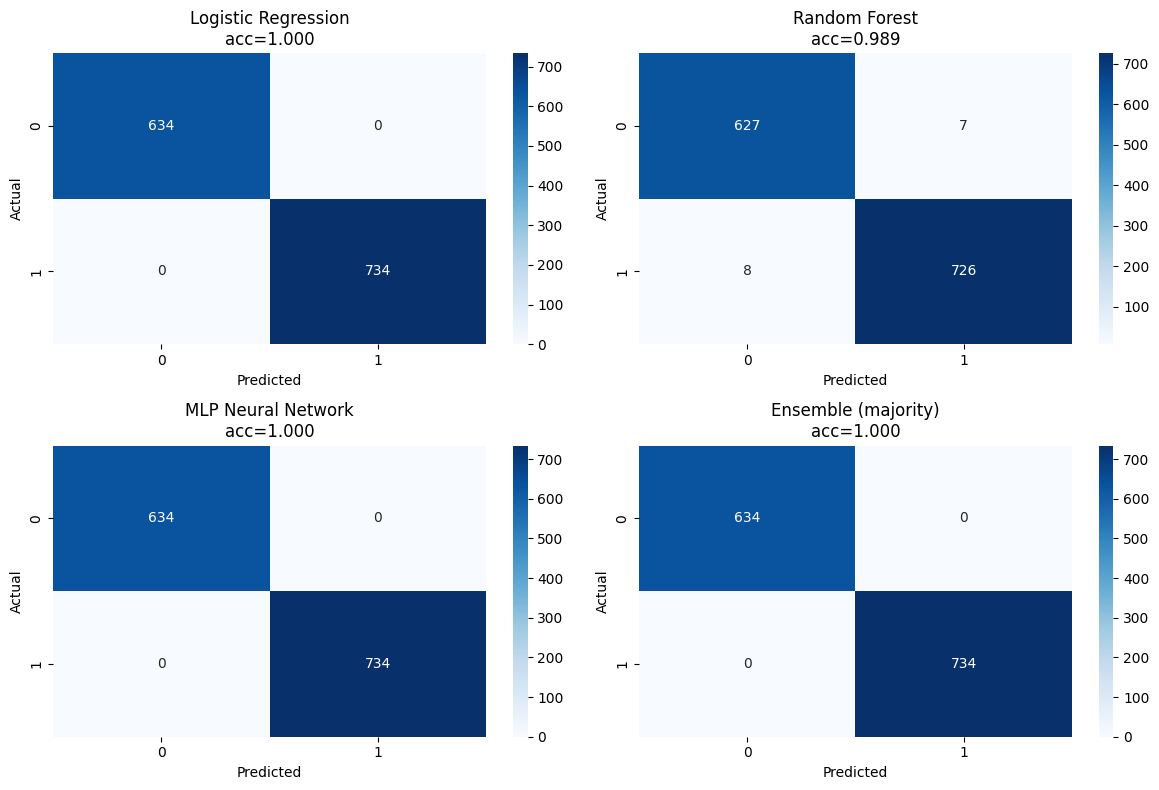

In [17]:
# Deterministic training + comparison + ensemble
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility (best-effort)
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# ---------- Prepare data ----------
# assume df is already loaded
target_col = df.columns[-1]
X = df.drop(target_col, axis=1)
y = df[target_col]

# use only numeric features (avoid conversion errors)
numeric_cols = X.select_dtypes(include=['number']).columns
X = X[numeric_cols]

# train/test split (no stratify if you previously had problems with rare classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# create scaler and scale (keep column names)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns, index=X_test.index)

# ---------- Define models (fixed random_state, n_jobs=1 for determinism) ----------
models = {
    'Logistic Regression': LogisticRegression(
        random_state=seed, max_iter=2000, solver='lbfgs', class_weight='balanced', n_jobs=1
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=150, max_depth=6, min_samples_split=3,
        class_weight='balanced', random_state=seed, n_jobs=1
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(128,64,32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=seed
    )
}

results = {}
metrics_rows = []

# ---------- Train and evaluate ----------
for name, model in models.items():
    print(f"\n--- Training {name} (seed={seed}) ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'y_pred': y_pred, 'accuracy': acc}
    
    pr, rc, f1, sup = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0, digits=4))
    
    # collect metrics for summary table
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
    metrics_rows.append({
        'model': name,
        'accuracy': acc,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    })

# ---------- Create a majority-vote ensemble of the three models ----------
voting = VotingClassifier(
    estimators=[(k, v['model']) for k, v in results.items()],
    voting='hard',  # majority vote
    n_jobs=1
)
voting.fit(X_train_scaled, y_train)
y_pred_ensemble = voting.predict(X_test_scaled)
acc_ens = accuracy_score(y_test, y_pred_ensemble)
results['Ensemble (majority)'] = {'model': voting, 'y_pred': y_pred_ensemble, 'accuracy': acc_ens}
print("\nEnsemble Accuracy: {:.4f}".format(acc_ens))
print(classification_report(y_test, y_pred_ensemble, zero_division=0, digits=4))
metrics_rows.append({
    'model': 'Ensemble (majority)',
    'accuracy': acc_ens,
    'precision_macro': precision_recall_fscore_support(y_test, y_pred_ensemble, average='macro', zero_division=0)[0],
    'recall_macro': precision_recall_fscore_support(y_test, y_pred_ensemble, average='macro', zero_division=0)[1],
    'f1_macro': precision_recall_fscore_support(y_test, y_pred_ensemble, average='macro', zero_division=0)[2],
})

# ---------- Summary table ----------
metrics_df = pd.DataFrame(metrics_rows).sort_values('accuracy', ascending=False).reset_index(drop=True)
print("\nSummary metrics:")
print(metrics_df)

# ---------- Plot confusion matrices side-by-side ----------
n = len(results)
cols = 2
rows = (n + 1) // cols
plt.figure(figsize=(6*cols, 4*rows))
for i, (name, info) in enumerate(results.items(), 1):
    cm = confusion_matrix(y_test, info['y_pred'])
    labels = np.unique(y_test)
    ax = plt.subplot(rows, cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'{name}\nacc={info["accuracy"]:.3f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# ---------- If you still see tiny differences ----------
# - Ensure you always use the same seed value (the 'seed' variable above).
# - Set n_jobs=1 to reduce nondeterminism from parallel threads.
# - For full reproducibility across machines, you may need environment-level deterministic settings.


In [ ]:
# -------------------------
# 10) Feature importance (for tree-based models)
# -------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if best_model exists and supports feature importances
try:
    if 'best_model' in globals() and hasattr(best_model, "feature_importances_"):
        fi = best_model.feature_importances_
        fi_df = pd.DataFrame({'feature': features, 'importance': fi}).sort_values('importance', ascending=False)
        print("\nFeature importances:\n", fi_df)

        plt.figure(figsize=(8,5))
        sns.barplot(x='importance', y='feature', data=fi_df)
        plt.title(f'Feature importances - {best_name}')
        plt.show()
    else:
        print("Feature importances are not available. Make sure 'best_model' is defined and tree-based.")
except Exception as e:
    print("Error:", e)


Feature importances are not available. Make sure 'best_model' is defined and tree-based.


Numeric columns detected: ['FTHG', 'FTAG', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'MW', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'FTR_encoded', 'HTFormPtsStr_num', 'ATFormPtsStr_num', 'ATFormPts_num', 'HTFormPts_num']


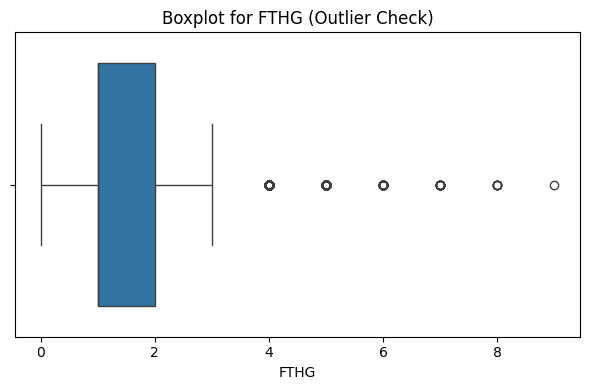

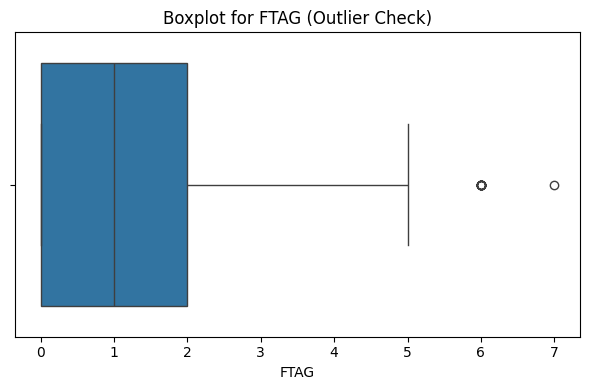

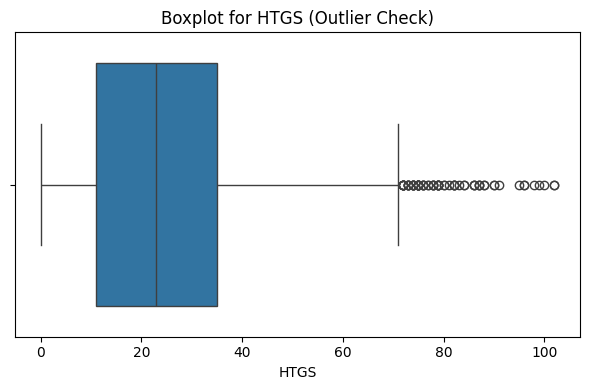

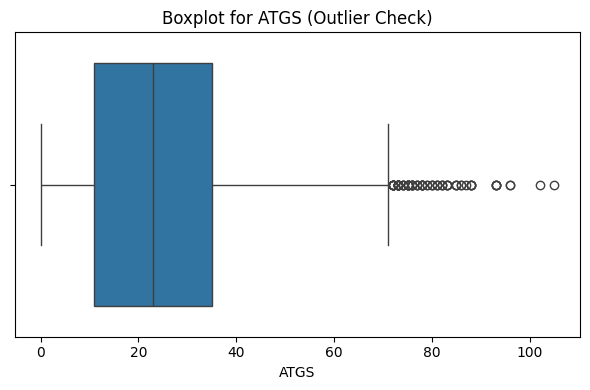

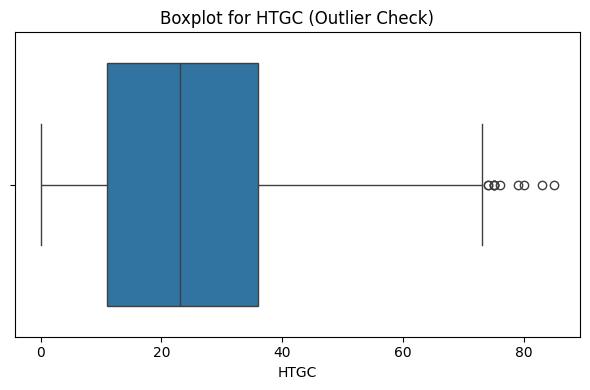

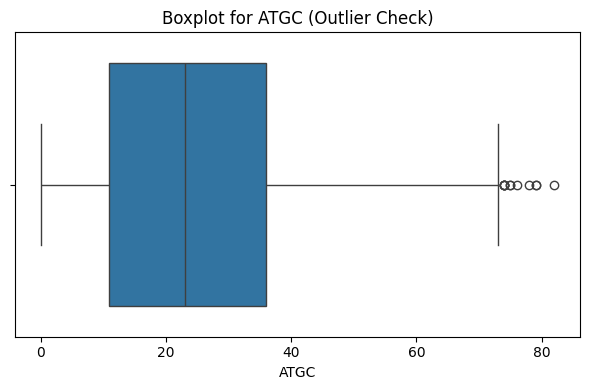

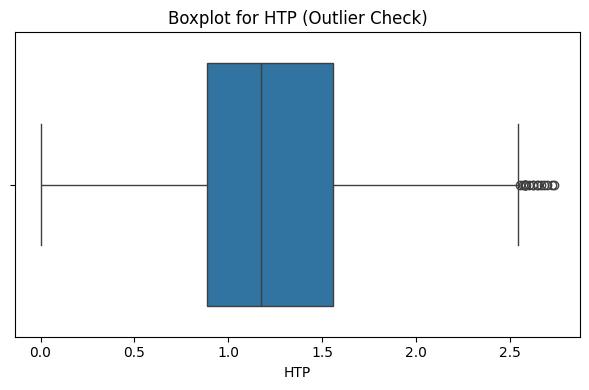

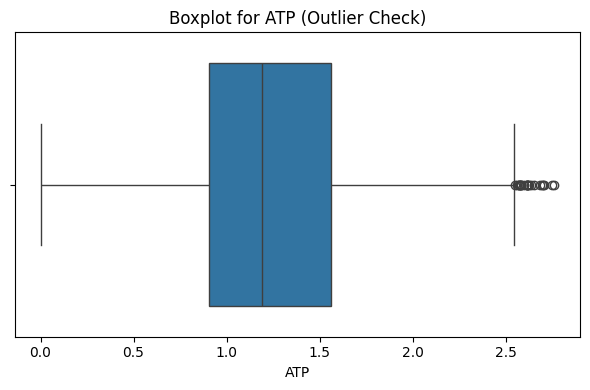

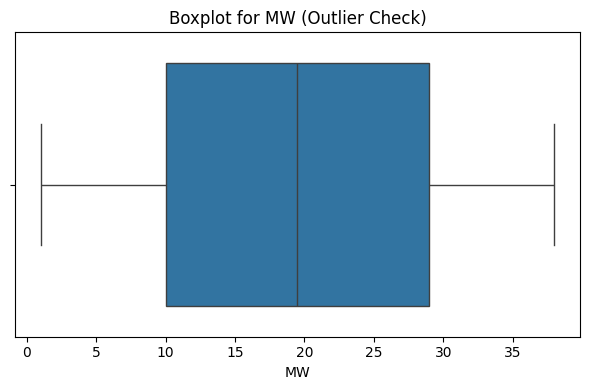

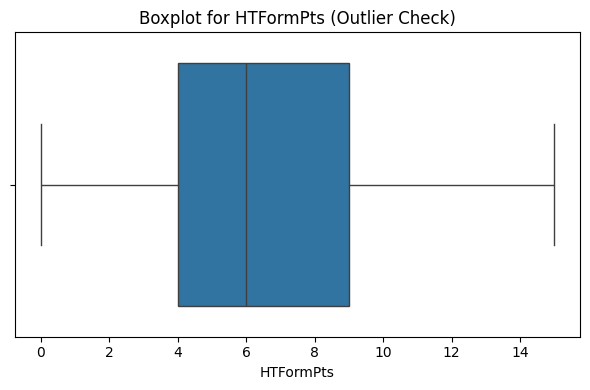

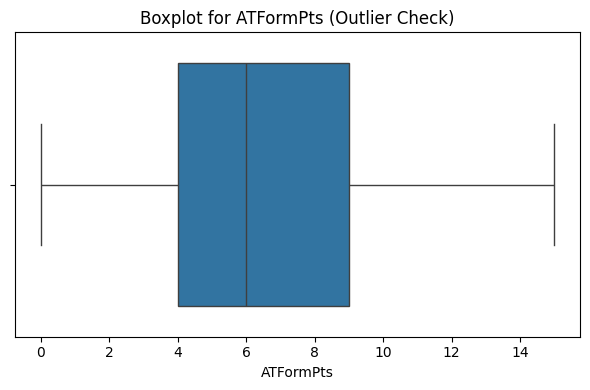

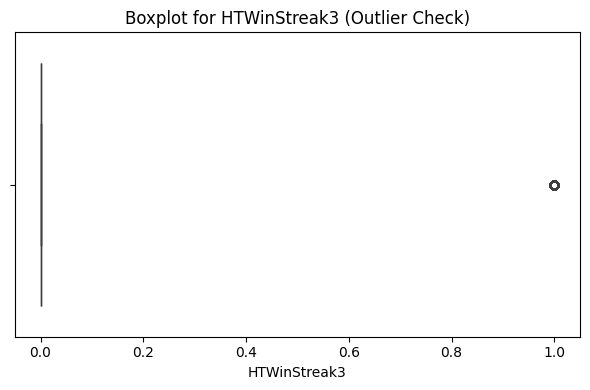

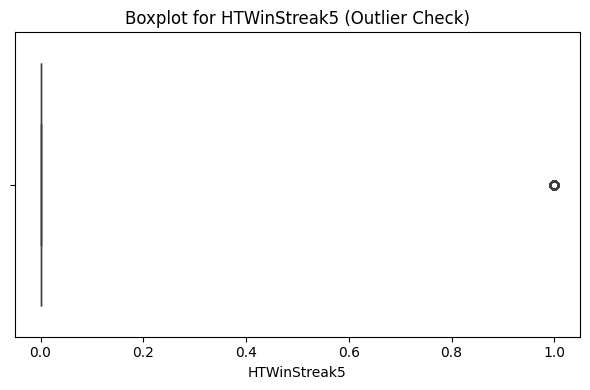

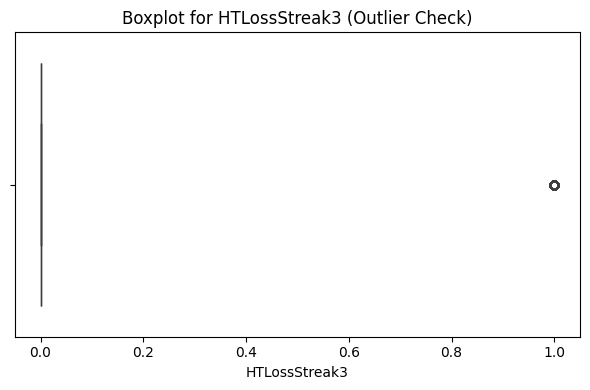

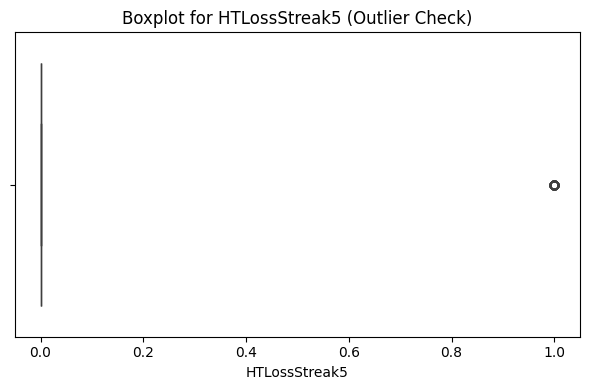

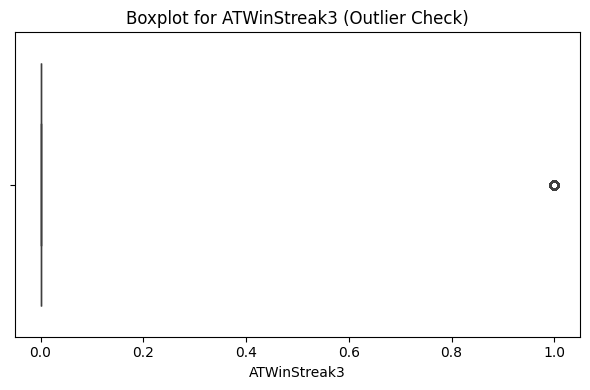

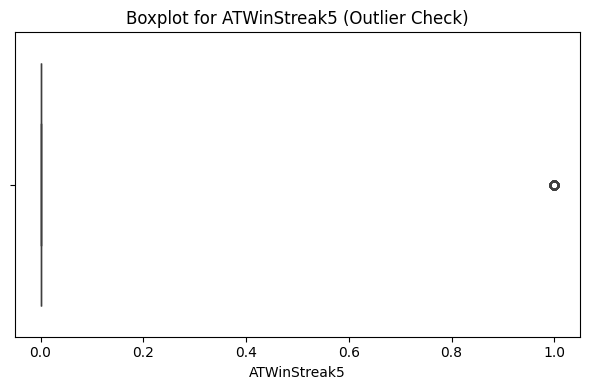

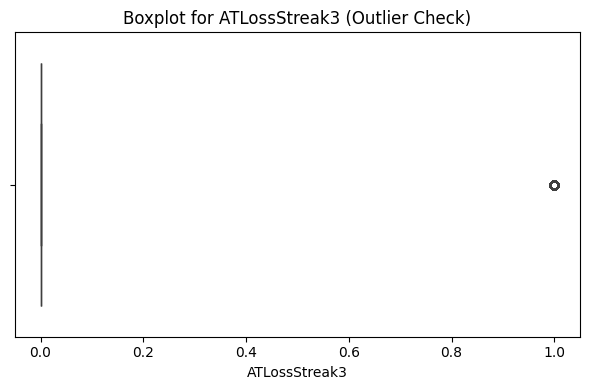

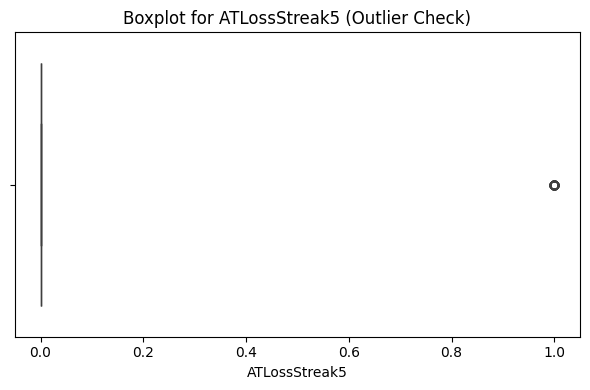

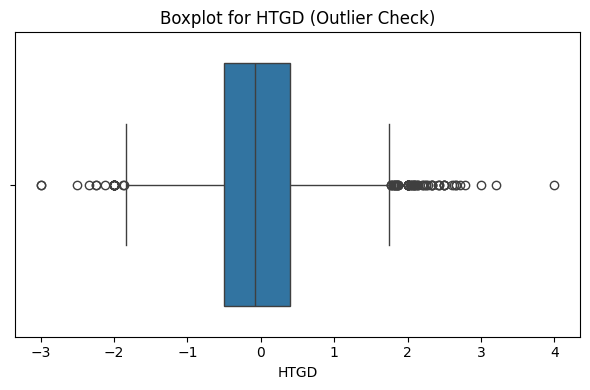

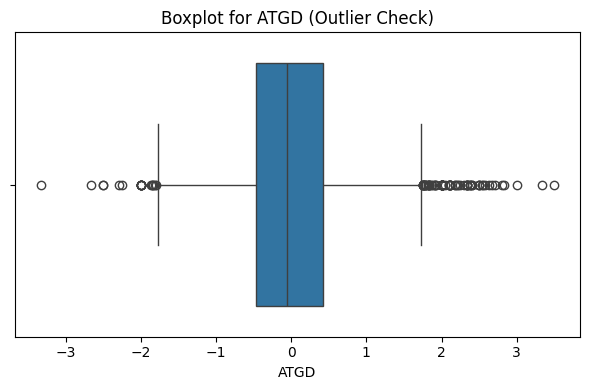

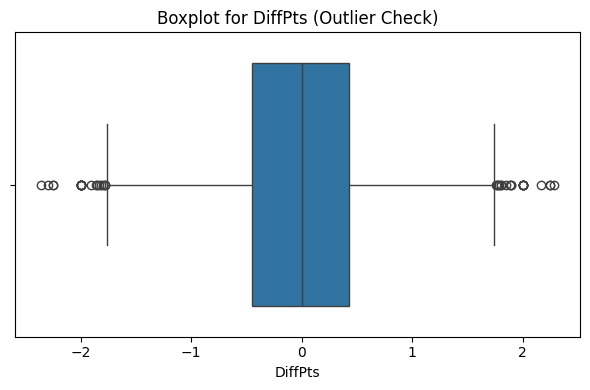

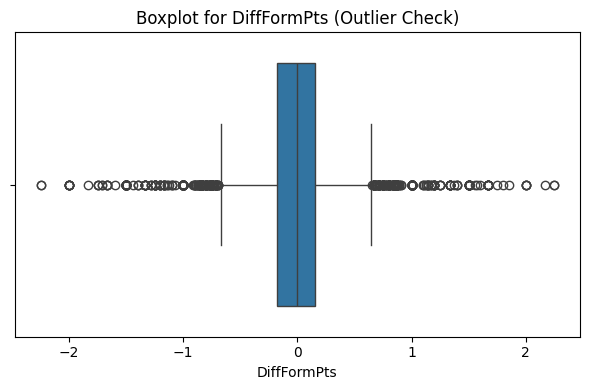

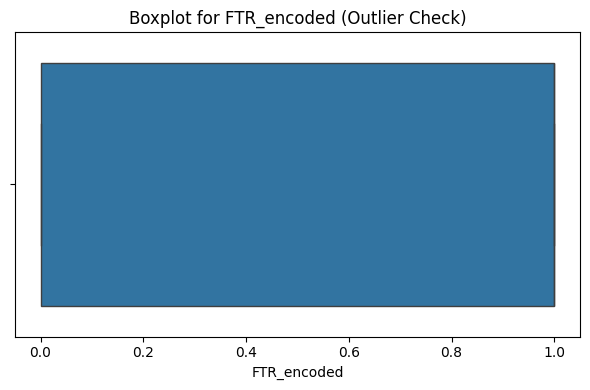

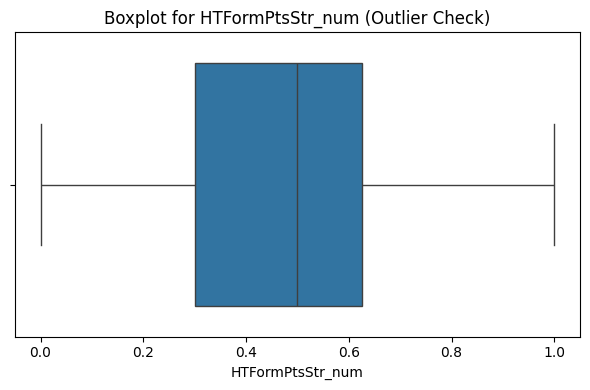

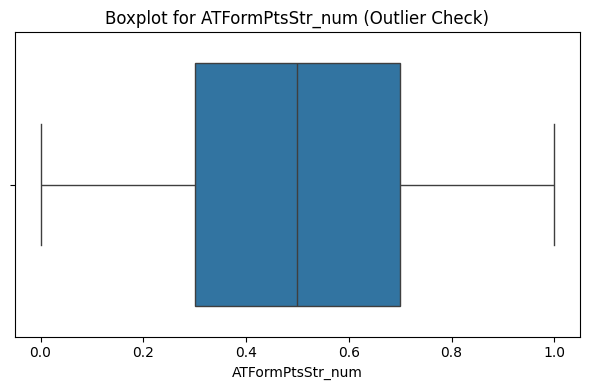

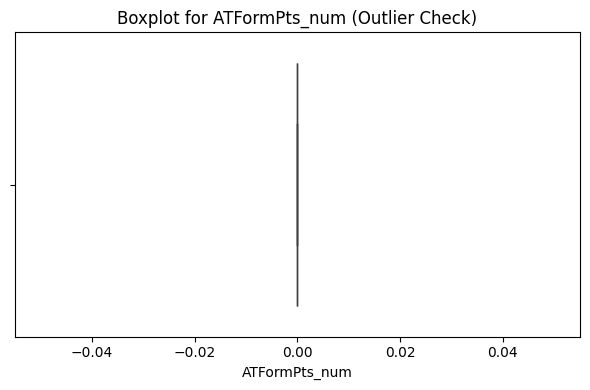

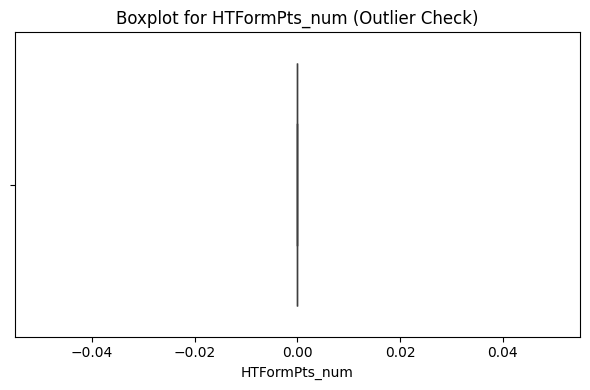

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy
df_plot = df.copy()

# -----------------------------------
# 1. Convert all form strings to numeric
# -----------------------------------
# You can add any form columns here
possible_form_cols = [
    'HTFormPtsStr', 'ATFormPtsStr', 
    'TFormPtsStr', 'ATFormPts', 'HTFormPts'
]

def form_to_numeric(s):
    mapping = {'W': 1, 'D': 0.5, 'L': 0}
    if isinstance(s, str):
        values = [mapping.get(ch, np.nan) for ch in s]
        # remove NaN if any character is invalid
        values = [v for v in values if not np.isnan(v)]
        return np.mean(values) if len(values) > 0 else 0
    return 0

# Convert only if the column exists
for col in possible_form_cols:
    if col in df_plot.columns:
        df_plot[col + "_num"] = df_plot[col].apply(form_to_numeric)

# -----------------------------------
# 2. Select numeric columns safely
# -----------------------------------
numeric_cols = df_plot.select_dtypes(include=['number']).columns

print("Numeric columns detected:", list(numeric_cols))

# -----------------------------------
# 3. Plot boxplots cleanly
# -----------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_plot, x=col)
    plt.title(f"Boxplot for {col} (Outlier Check)")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [ ]:
import joblib

# --- Make sure these exist from your training step ---
# results = {...}  # dictionary of trained models
# X_train_scaled = ...  # scaled training features
# scaler = ...  # scaler used to scale X_train

# 1) Check that results exist and are not empty
if 'results' in globals() and results:
    best_name = max(results, key=lambda k: results[k]['accuracy'])
    best_model = results[best_name]['model']
else:
    raise ValueError("Error: 'results' dictionary not found or empty. Train models first.")

# 2) Check that scaler exists
if 'scaler' not in globals():
    raise ValueError("Error: 'scaler' not found. Make sure you have scaled your features before saving.")

# 3) Save model and scaler
MODEL_OUT = "best_match_model.pkl"
SCALER_OUT = "scaler.pkl"

joblib.dump(best_model, MODEL_OUT)
joblib.dump(scaler, SCALER_OUT)

print(f"\nSaved best model to {MODEL_OUT} and scaler to {SCALER_OUT}")



Saved best model to best_match_model.pkl and scaler to scaler.pkl
